# Light-harvesting Fenna–Matthews–Olson (FMO) Complex

The FMO complex is a pigment-protein complex that can be found in green sulfur bacteria. It mediates the transfer of energy (excited electronic states, i.e., *exciton*) from the light-harvesting chlorosomes (antenna) to the reaction centre. [[wiki]](https://en.wikipedia.org/wiki/Fenna%E2%80%93Matthews%E2%80%93Olson_complex)

The FMO complex has 7 chromophores (sites) that can host an exciton with different energies $\varepsilon_i$. The chromophores are coupled to each other via Coulomb (dipole-dipole) interactions $V_{ij}$, which mediates the transfer (hopping) of an exciton between chromophores.

Reference for the model: [**Environment-assisted quantum walks in photosynthetic energy transfer**](https://doi.org/10.1063/1.3002335)


## Import modules and packages

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from diagnostics import density_matrix_positivity, trajectory_min_eigs
from plotting import style, plot_min_eig, plot_coherences, plot_populations
style()

## System Hamiltonian

Set up the system Hamiltonian for the *single-excitation* manifold, i.e., the subspace of states with exactly one exciton in the system. The Hamiltonian can be constructed from the local exciton energies ($\varepsilon_i$) for each chromophore and the inter-chromophore couplings ($V_{ij}$):

$H = \sum_{i} \varepsilon_{i}|i\rangle\langle i| + \sum_{(i,j)} \bigg( V_{ij}|i\rangle\langle j| +  h.c. \bigg) $.

**Note:** All energies and couplings are given in units of $\textrm{cm}^{-1} = 0.123983\textrm{meV}$.

Use the following energies $\varepsilon_i$, numbering the sites as $i=0,\dots,6$: 
- `[280, 420, 0, 175, 320, 360, 260]`,

Use the following couplings $V_{ij}$ for between sites $(i,j)$ in the format `(i,j,coupling)`: 
- `[(0,1,-106), (0,6,-8), (1,2,28), (1,5,13), (2,3,-62), (2,6,17), (3,4,-70), (3,5,-19), (3,6,-57), (4,5,40), (4,6,-2), (5,6,32)]`.


In [71]:
# exciton energy of each site (i = 0,...,6)
energies = [280, 420, 0, 175, 320, 360, 260]

# exciton couplings (i, j, coupling)
couplings = [(0,1,-106), (0,6,-8), (1,2,28), (1,5,13), (2,3,-62), (2,6,17),
             (3,4,-70), (3,5,-19), (3,6,-57), (4,5,40), (4,6,-2), (5,6,32)]

# dimension
dim = len(energies)

# build Hamiltonian using QuTiP
H_qt = qt.Qobj(np.diag(energies))

# add couplings
for i, j, V in couplings:
    # |i><j| + |j><i|
    H_qt += V * (qt.basis(dim, i) * qt.basis(dim, j).dag() + qt.basis(dim, j) * qt.basis(dim, i).dag())

## Eigenstates and delocalisation

Find the eigenenergies $\omega_k$ and eigenstates $|\psi_k\rangle$ of the system, $H|\phi_k\rangle = \omega_k |\phi_k\rangle$. Then calculate and plot the **inverse participation ratio** $\mathrm{IPR}(\phi_k)$ for each eigenstate,

$\mathrm{IPR}(\phi_k):=\bigg(\sum_{i}|\langle \phi_k | i\rangle |^4\bigg)^{-1}$.

The $\mathrm{IPR}$ represents the degree of delocalisation of a state. Test the following statements.
- Localised state have $\mathrm{IPR}=1$
- Delocalised states have $\mathrm{IPR}>1$
- Perfectly delocalised states $\sum_{i=1}^{N}|i\rangle/\sqrt{N}$ states have $\mathrm{IPR}=N$.

If you want sorted eigenstates you can use `eigensorter` from `tools`.

localised state: IPR = 1.0
delocalised state: IPR = 1.6080454308880252
perfectly delocalised state: IPR = 343.0000000000003


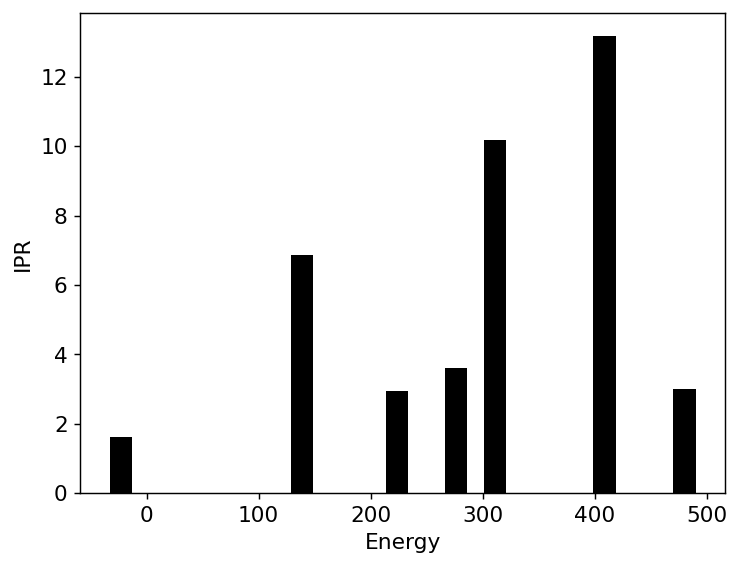

In [72]:
# eigenstates
evals, evecs = H_qt.eigenstates()

# IPR
def IPR(state):
    # state is Qobj ket
    coeffs = [qt.expect(qt.basis(dim, i) * qt.basis(dim, i).dag(), state) for i in range(dim)]
    return 1 / np.sum(np.abs(coeffs)**4)

# plot IPR for each state
iprs = np.array([IPR(evec) for evec in evecs])
fig, ax = plt.subplots()
ax.bar(evals, iprs, color='black', width=20);
ax.set_xlabel('Energy');
ax.set_ylabel('IPR');

# test IPR
print('localised state: IPR =', IPR(qt.basis(dim, 0)));
print('delocalised state: IPR =', IPR(evecs[0]));
print('perfectly delocalised state: IPR =', IPR(sum(qt.basis(dim, i) for i in range(dim)) / np.sqrt(dim)));

## IPR as a function of temperature

Thermal states are given by $G_\beta[H]:=\exp(-\beta H)/\mathrm{Tr}\exp(-\beta H)$, where 
- $\beta^{-1} = k_B T$ and
- $k_B = 0.695 035 6(12) \mathrm{cm}^{-1}/K$ is the Boltzmann constant.

Calculate the $\mathrm{IPR}$ for the thermal states of the system for the following interval of temperatures:

- $T = [7K, 300K]$.

**Note**: How could we generalise the $\mathrm{IPR}$ to density operators? 

<details>
<summary> Hint </summary>
<redfield>
Any density operator can be written as $\rho = \sum_i p_i |r_i\rangle\langle r_i|$, in some basis.
</details>

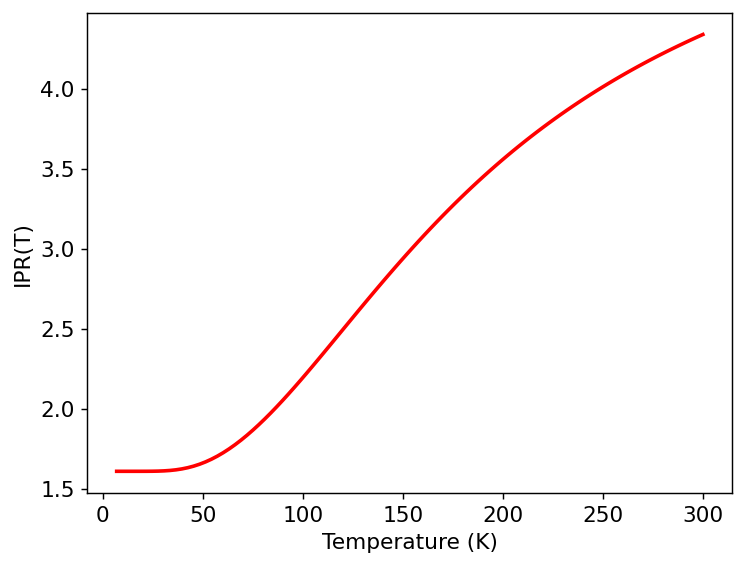

In [73]:
from scipy.linalg import expm

# thermal state
def G(H, T, kB=0.6950):
    beta = 1 / (kB * T)
    temp = expm(-beta * H.full())
    return temp / np.trace(temp)

# temperatures
Ts = np.linspace(7, 300, 100)

# thermal states
thermal_states = [qt.Qobj(G(H_qt, T)) for T in Ts]

# generalise IPR to mixed states
def meanIPR(rho):
    # eigenvalues and eigenstates of rho
    ps, ekets = np.linalg.eig(rho.full())
    # return average IPR
    return np.sum([ps[k] * IPR(qt.Qobj(ekets[:, k])) for k in range(len(ps))])

# mean IPRs
mean_iprs = np.array([meanIPR(state) for state in thermal_states])

# plot
fig, ax = plt.subplots()
ax.plot(Ts, mean_iprs, color='red');
ax.set_xlabel('Temperature (K)');
ax.set_ylabel('IPR(T)');

## Decoherence model

Using Bloch-Redfield theory, calculate the Redfield tensor $R$ (in the basis of the Hamiltonian) associated with the thermal relaxation process $\dot{\rho}=R[\rho]$ under the following conditions:

- Use the following (Ohmic) noise power spectrum $S(\omega,\eta,\omega_c,\beta) = 2\pi\eta\omega\exp(-|\omega|/\omega_c)[1-\exp(-\omega\beta)]^{-1}$, where:
    - $\beta^{-1}= k_B T$ is the *inverse temperature* of the bath, using $T = 300 K$, 
    - $\eta=1$ ($\textrm{cm}^{-1}$) is the *reorganisation energy*, and
    - $\omega_c = 150$ ($\textrm{cm}^{-1}$) is the *cut-off energy* of the Ohmic model.
- Use local exciton states as the coupling operators $A_i = |i\rangle\langle i|$;
- Work in the secular approximation, using a *machine-precision* cut-off value condition `secular_cut_off = 1e-15`

To construct the Redfield tensor use the [Script 4.1](https://github.com/frnq/qme/blob/main/python/bloch_redfield_tensor.py) from the [tutorial](https://arxiv.org/abs/2303.16449).

In [74]:
# parameters
T = 300            # Temperature in Kelvin
eta = 1            # reorganisation energy
wc = 150           # Ohmic cut-off frequency

# bath
bath = qt.OhmicEnvironment(T=T, wc=wc, alpha=eta, s=1.0)

# coupling operators
a_ops = [[qt.basis(dim, i) * qt.basis(dim, i).dag(), bath] for i in range(dim)]

## Dynamics

- Calculate the transient population $p_3(t)=\mathrm{Tr}[\rho(t)|3\rangle\langle 3|]$ of the target site $i = 3$ (which is the closest to the reaction centre), assuming that the initial state $|\psi_0\rangle = |1\rangle$ is an exciton localised on site $i=1$.

- Consider the time interval from $t_0=0$ to $t_f=1$ (in the $\mathrm{cm}^{-1}$ units)

- When is the target site maximally populated?

- Compare the steady-state population of the target state $\lim_{t\to\infty}p_3(t)$ with the target state population at thermal equilibrium $\mathrm{Tr}[G(H,\beta)|3\rangle\langle 3|]$.

- Do you see any (Rabi-like) oscillation in the transient population $p_3(t)$? What happens if you increase or decrease the value of $\eta$ in the Redfield tensor?. 

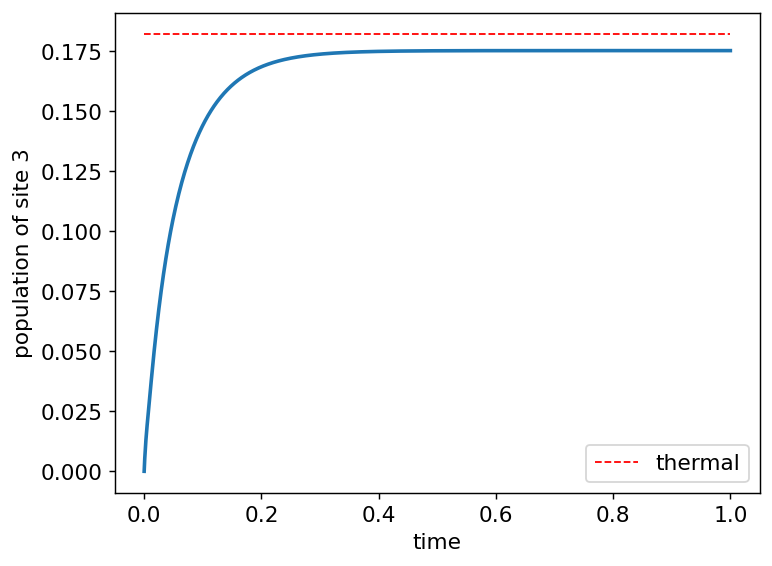

In [75]:
# thermal state
kB = 0.6950
beta = 1 / (kB * T)
thermal_dm = (-beta * H_qt).expm()
thermal_dm = thermal_dm / thermal_dm.tr()

# initial state
psi0 = qt.basis(dim, 1)  # site 1

# initial state as density operator
rho0 = psi0 * psi0.dag()

# target operator
O = qt.basis(dim, 3) * qt.basis(dim, 3).dag()  # site 3

# initial and final time
t, tf = 0, 1

# times
times = np.linspace(t, tf, 1000)

# solve with QuTiP
result = qt.brmesolve(H=H_qt, psi0=rho0, tlist=times, a_ops=a_ops, e_ops=[O], options={"store_states": True})

# data
data = result.expect[0]

# thermal population
p_thermal = qt.expect(O, thermal_dm)

# figure
fig, ax = plt.subplots()
# plot the time-dependent population of the target site
ax.plot(times, data)
# plot the population of the target site at thermal equilibrium
ax.hlines(p_thermal, times[0], times[-1], colors='red', linewidths=1, linestyles='dashed', label='thermal');
ax.set_xlabel('time');
ax.set_ylabel('population of site 3');
ax.legend();

##### Population of the reaction centre

Calculate the population of the reaction centre assuming that:

- Exciton transfer to the reaction centre can only occur from the target site $i=3$;
- $\gamma_0 = 1$ is the transfer rate from the target site (3) to the reaction centre;
- $\tau = 10$ is the exciton lifetime, identical for every exciton (on every site);

To do that, you can consider an additional state $|\mathrm{rc}\rangle$ corresponding to the reaction centre, and an additional state corresponding to the ground state (vacuum) of the system $|0\rangle$, such that:

- $|3\rangle \to |\mathrm{rc}\rangle$ occurs at rate $\gamma_0$,
- $|i\rangle \to |0\rangle$ occurs at rate $\tau$ for every site $i  = 1, \dots, 7$.

In [76]:
# Lindblad operators
c_ops = ([np.sqrt(1/tau) * (qt.basis(dim, dim-2) * qt.basis(dim, i).dag()) for i in range(7)]
         + [np.sqrt(g0) * (qt.basis(dim, dim-1) * qt.basis(dim, 3).dag())])

### Propagate

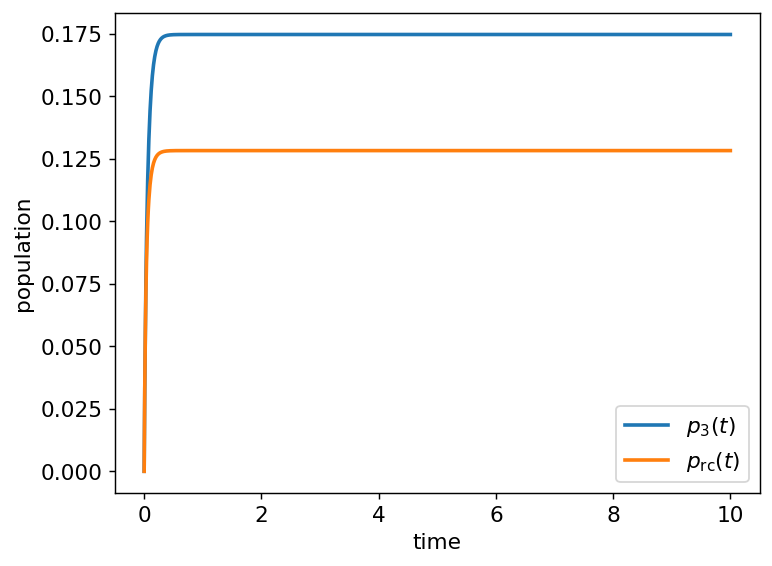

In [77]:
# initial state
psi0 = qt.basis(dim, 1)  # site 1

# initial state as density operator
rho0 = psi0 * psi0.dag()

# target operator
O = qt.basis(dim, 3) * qt.basis(dim, 3).dag()  # site 3

# reaction centre operator
RC = qt.basis(dim, dim-1) * qt.basis(dim, dim-1).dag()

# initial and final time
t, tf = 0, 10

# times
times = np.linspace(t, tf, 1000)

# solve with QuTiP
result = qt.brmesolve(H=H_qt, psi0=rho0, tlist=times, a_ops=a_ops, c_ops=c_ops, e_ops=[O, RC], options={"store_states": True})

# data
data_target = result.expect[0]
data_rc = result.expect[1]

# figure
fig, ax = plt.subplots()
# plot the time-dependent population of the target site
ax.plot(times, data_target, label=r'$p_3(t)$')
ax.plot(times, data_rc, label=r'$p_\mathrm{rc}(t)$')
# plot the population of the target site at thermal equilibrium
ax.set_xlabel('time');
ax.set_ylabel('population');
ax.legend();

## Comparison of mesolve and brmesolve

Compare the dynamics using `brmesolve` (Bloch-Redfield with both Redfield and Lindblad terms) and `mesolve` (Lindblad master equation with only Lindblad terms).

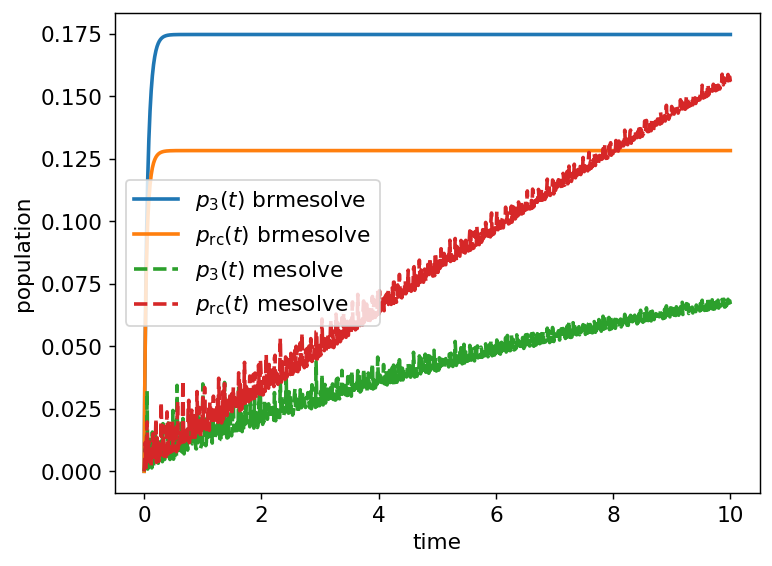

In [79]:
# Comparison using mesolve (Lindblad only)
result_mesolve = qt.mesolve(H=H_qt, rho0=rho0, tlist=times, c_ops=c_ops, e_ops=[O, RC])

data_target_mesolve = result_mesolve.expect[0]
data_rc_mesolve = result_mesolve.expect[1]

# Plot comparison
fig, ax = plt.subplots()
ax.plot(times, data_target, label=r'$p_3(t)$ brmesolve')
ax.plot(times, data_rc, label=r'$p_\mathrm{rc}(t)$ brmesolve')
ax.plot(times, data_target_mesolve, label=r'$p_3(t)$ mesolve', linestyle='--')
ax.plot(times, data_rc_mesolve, label=r'$p_\mathrm{rc}(t)$ mesolve', linestyle='--')
ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend()